# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Общая информация

In [1]:
# Импорт нужных библиотек
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #читаем файл

In [3]:
data.head() #выводим первые 5 строк

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
data.info()#смотрим общую информацию о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.isna().sum()#считаем все пропуски

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [10]:
data.duplicated().sum()#проверим наличие явных дубликатов

0

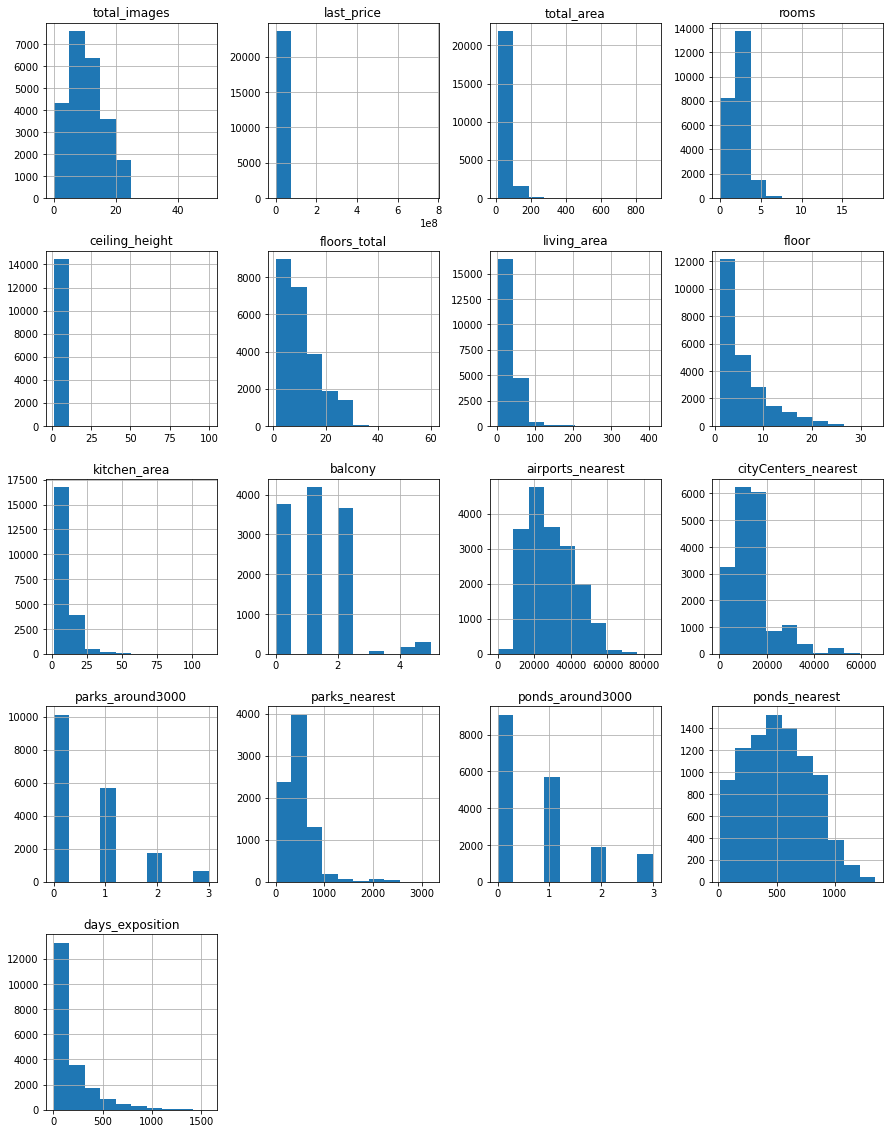

In [11]:
data.hist(figsize=(15, 20));#строим гистограммы для всех числовых значений

Вывод:
<br> Изучена общая информация о данных, по которой можно сказать, что у ряда столбцов наблюдаются пропущенные значения и некорректный тип данных. По гисторгаммам видно, что в данных есть аномальные значения. Явные дубликаты отсутствуют. 
<br> Дальнейший план действия по предобработке данных:
<br> 1. Привести название столбцов cityCenters_nearest к city_centers_nearest и ponds_around3000 к ponds_around_3000
<br> 2. Обработать пропущенные значения.
<br> 3. В столбцах необходимо изменить тип данных:
* floors_total, balcony и days_exposition - int.
* is_apartment - bool.
* а first_day_exposition - datetime.

## Выполните предобработку данных

### Приведение названий столбцов cityCenters_nearest и ponds_around3000 к эталонному:

In [12]:
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest', 'ponds_around3000':'ponds_around_3000', "\n"
 'parks_around3000':'parks_around_3000'})#переименование столбца

In [13]:
#начинаем с столбца ceiling_height, просмотрим общие данные по этому столбцу
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [14]:
#максимальное значение в этом столбце не похоже на правду, посмотрим сколько их 
data.loc[data['ceiling_height']>5, 'ceiling_height'].count()

36

In [15]:
"""предлагаю заполнить пропущенные значения медианой, высоких значений не много, 
поэтому они не повлияют на медиану, исправлять их не буду"""
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median() 
data['ceiling_height'].isna().sum()#проверяем пропущенные значения

0

### Обработка пропущенных значений столбца floors_total:

In [16]:
# следующий столбец с пропущенными значениями floors_total,для каждого из этажей посчитаем медиану количества этажей в доме.
#создадим функцию, которая значения больше нуля оставляет прежними, а отрицательные или пропущенные значения заполняет медианой
def floors_total_median(row):
    if row['floors_total'] > 0:
        return row['floors_total']
    else:
        median_floors_total = data[(data['floor'] == row['floor']) & (data['floors_total'] >= 0)]['floors_total'].median()
        return median_floors_total
data['floors_total'] = data.apply(floors_total_median, axis=1)#сохраняем в столбец значения, возвращенные функцией
data['floors_total'].isna().sum()#провряем пропущенные значения

0

In [17]:
data[data['floors_total'] < data['floor']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition


### Обработка пропущенных значений столбца living_area:

Следующее значение, которое нужно найти living_area - жилая площадь. У нас есть общая площадь, в которую входят площади комнат, кухонь, балконов, кладовых, гардеробных и т.д. Подобных данных у нас мало. С другой стороны жилая площадь - площадь комнат, то есть можно посчитать медианное значение жилой площади по количеству комнат и заполнить этим значением жилую площадь в зависимости от количества комнат.

In [18]:
"""создадим функцию аналогично предыдущей, для каждых N комнат она проверит жилую площадь, 
если значение заполнено, то она вернёт это же значение, если нет, то посчитает медианное для каждых N комнат"""
def living_area_median(row):
    if row['living_area'] > 0:
        return row['living_area']
    else:
        median_living_area = data[(data['rooms'] == row['rooms']) & (data['living_area'] >= 0)]['living_area'].median()
        return median_living_area
data['living_area'] = data.apply(living_area_median, axis=1)#сохраняем в столбец значения, возвращенные функцией
data['living_area'].isna().sum()#провряем пропущенные значения

0

### Обработка пропущенных значений столбца is_apartment:

In [19]:
"""следующим значением для замены является is_appartment, у нас нет никаких данных, по которым можно восстановить это значение. 
Проверим соотношение аппартаментов и не аппартаментов."""
data.groupby('is_apartment').agg({'rooms':'count'})

,rooms
is_apartment,
False,2725
True,50


In [20]:
"""Значений False значительно больше, скорее всего данный пункт продавцом просто не заполнялся, 
поэтому заменим пропущенные значения на False"""

data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].isna().sum()#провряем пропущенные значения

0

### Обработка пропущенных значений столбца kitchen_area:

Для заполнения пропусков в столбце площадь кухни попробуем по заполненным значениям вычислить коэффициент соотношения площади кухни к общей площади и по нему заполнить пропущенные значения. 

In [21]:
'''проверяем, есть ли строки, в которых жилая площади и площадь кухни превышает 90% от 
общей площади(так как кроме кухни считается санузел, коридор и др)'''
data.query('(living_area+kitchen_area)>0.9*total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04T00:00:00,3,2.65,14.0,59.0,8,False,...,12.0,5.0,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22T00:00:00,2,2.50,9.0,38.0,8,False,...,10.0,1.0,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,False,...,6.2,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,False,...,9.0,NaN,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19T00:00:00,3,2.50,5.0,47.4,4,False,...,6.4,1.0,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23216,15,10150000.0,114.0,2015-01-21T00:00:00,4,2.65,5.0,90.2,4,False,...,16.0,NaN,Санкт-Петербург,26259.0,4961.0,0.0,NaN,2.0,838.0,1052.0
23297,10,1850000.0,48.2,2019-03-13T00:00:00,2,2.65,5.0,42.2,2,False,...,6.0,1.0,Высоцк,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23328,12,4299000.0,54.0,2016-11-25T00:00:00,2,2.65,14.0,40.0,8,False,...,10.0,0.0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23521,13,8500000.0,65.0,2018-11-01T00:00:00,2,2.65,4.0,44.0,2,False,...,15.3,NaN,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN


Таких строк 462, из этих значений мной было заполнено поле living_area, нужно проверить повляло ли это. 
<br>Для проверки я выведу пару строк их полученных выше данных по их индексу.Но перед эти закомментирую свою функцию, которая заполняет пропущенные значения в living_area, чтобы видеть исходный датафрейм.
<br>Стало ясно, что ошибка в исходных данных, они были заполнены некорректно. Исправить их нет возможности, поэтому заполняю так как есть.

In [22]:
data.iloc[[184,220]]#вывожу строки 184 и 220

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
184,7,2600000.0,30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,False,...,6.2,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09T00:00:00,1,2.50,25.0,28.0,6,False,...,9.0,NaN,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0


In [23]:
#вычисляем значения площади кухни с учетом коэффициента
ratio_kitchen_area = (data['kitchen_area'].sum() / data['total_area'].sum())*data['total_area'].round(2)
ratio_kitchen_area

0        17.097514
1         6.395737
2         8.865378
3        25.171340
4        15.831032
           ...    
23694    21.183504
23695     9.340309
23696     8.976195
23697    12.150317
23698     5.113423
Name: total_area, Length: 23699, dtype: float64

In [24]:
#заменяем пропущенные значения на полученные с учетом коэффициента
data['kitchen_area'] = data['kitchen_area'].fillna(ratio_kitchen_area)
data['kitchen_area'].isna().sum()#провряем пропущенные значения

0

### Обработка пропущенных значений столбца balcony:

Вычислить количество балконов по имеющимся данным нет возможности. Скорее всего продавец просто не заполнял данное поле, если у него нет балкона. Поэтому все пропущенные значения заменим на 0.

In [26]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()#провряем пропущенные значения

0

### Обработка пропущенных значений столбца locality_name:

In [27]:
#посмотрим данные в столбце
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [28]:
#убирем лишние слова в именах локаций
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['деревня', 'поселок', 'городского типа', 'садовое товарищество', 'городского типа', 'село', 'городской', 'садовое некоммерческое товарищество', 'при железнодорожной станции', 'станции', 'садоводческое некоммерческое товарищество', 'коттеджный', 'имени', 'пансионат'], '', regex=True)) 
data['locality_name'].sort_values().unique()#отсортируем по алфавиту 

array(['   Морозова', '   Свердлова', '  Большая Ижора', '  Будогощь',
       '  Важины', '  Вещево', '  Виллози', '  Вознесенье', '  Вырица',
       '  Громово', '  Дружная Горка', '  Дубровка', '  Ефимовский',
       '  Кивеннапа Север', '  Кондратьево', '  Корнево', '  Красный Бор',
       '  Кузнечное', '  Кузьмоловский', '  Лебяжье', '  Лесное',
       '  Лесогорский', '  Лужайка', '  Мга', '  Назия', '  Никольский',
       '  Новоселье', '  Павлово', '  Приветнинское', '  Приладожский',
       '  Рахья', '  Рощино', '  Рябово', '  Свирь', '  Свирьстрой',
       '  Сиверский', '  Синявино', '  Советский', '  Счастье', '  Тайцы',
       '  Токсово', '  Ульяновка', '  Федоровское', '  Форносово',
       '  Янино-1', ' Агалатово', ' Александровская', ' Алексеевка',
       ' Аннино', ' Аро', ' Барышево', ' Батово', ' Бегуницы',
       ' Белогорка', ' Белоостров', ' Большая Вруда',
       ' Большая Пустомержа', ' Большие Колпаны', ' Большое Рейзино',
       ' Большой Сабск', ' Бор', ' 

In [29]:
#заполнить пропуски в данном столбце невозможно, нет достаточной информации, поэтому просто заменим их на unknown
data['locality_name'] = data['locality_name'].fillna('unknown')
data['locality_name'].isna().sum()#провряем пропущенные значения

0

### Обработка пропущенных значений столбца airports_nearest:

In [33]:
#расстояние до аэропорта заполним медианным значением от местоположения до аэропорта
#создадим функцию, которая посчитает медианное расстояние от locality_name
def airports_nearest_median(row):
    if row['airports_nearest'] >= 0:
        return row['airports_nearest']
    else:
        median_airports_nearest = data[(data['locality_name'] == row['locality_name']) &\
        (data['airports_nearest'] >= 0)]['airports_nearest'].median()
        return median_airports_nearest
data['airports_nearest'] = data.apply(airports_nearest_median, axis=1)#сохраняем в столбец значения, возвращенные функцией
data['airports_nearest'].isna().sum()#провряем пропущенные значения

4863

Таким способом удалось заполнить всего лишь часть пропусков, в остальных случаях для всех значений одного местоположения поле расстояния до аэропорта не заполнено, значит, скорее всего, его в принципе нет в этой локации либо он находится слишком далеко. Оставшиеся пропуски оставим неизменными, они не повлияют на наш дальнейший расчет.

### Обработка пропущенных значений столбца city_centers_nearest:

In [34]:
#расстояние до центра города заполним медианным значением от местоположения до центра
#создадим функцию, которая посчитает медианное расстояние от locality_name
def city_centers_nearest_median(row):
    if row['city_centers_nearest'] >= 0:
        return row['city_centers_nearest']
    else:
        median_city_centers_nearest = data[(data['locality_name'] == row['locality_name']) & \
        (data['city_centers_nearest'] >= 0)]['city_centers_nearest'].median()
        return median_city_centers_nearest

In [35]:
data['city_centers_nearest'] = data.apply(city_centers_nearest_median, axis=1)#сохраняем в столбец значения
data['city_centers_nearest'].isna().sum()#провряем пропущенные значения

4863

Таким способом удалось заполнить всего лишь часть пропусков, в остальных случаях для всех значений одного местоположения поле расстояния до центра не заполнено, значит, скорее всего, объект находится не в городе. Оставшиеся пропуски оставим неизменными, они не повлияют на наш дальнейший расчет.

### Обработка пропущенных значений столбца parks_nearest:

Для всех значений одного местоположения поле расстояния до ближайшего парка не заполнено, значит, объект находится далеко от парка. Оставшиеся пропуски оставим неизменными, они не повлияют на наш дальнейший расчет.

### Обработка пропущенных значений столбца ponds_around_3000:

Расстояние до ближайшего парка не заполнено, значит, скорее всего, объект находится далеко от парка. Все значения оставим неизменными, они не повлияют на наш дальнейший расчет.

###  Обработка пропущенных значений столбца ponds_nearest:

Расстояние до ближайшего водоёма не заполнено, значит, скорее всего, рядом с объектом нет водоемов. Все значения оставим неизменными, они не повлияют на наш дальнейший расчет.

###  Обработка пропущенных значений столбца days_exposition:

Незаполненные пропуски, возможно, указывают, что объект не продан, оставим столбец неизменным.

In [39]:
#снова проверим пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4863
city_centers_nearest     4863
parks_around3000         5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [40]:
#поменяем тип данных
data['floors_total']=data['floors_total'].astype('int')
data['balcony']=data['balcony'].astype('int')
data['is_apartment']=data['is_apartment'].astype('bool')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')


**Вывод:**
<br> В ходе предобработки данных заполнены или уменьшены пропуски в данных. В столбце высота потолков присутствуют аномальные значения, но я их не стала обрабатывать, так как таких записей всего 36 и они не повлияют на медиану. 
<br>Найдены ошибки при заполнении данных. Так, например,в исходных данных в 492 строках сумма площадей кухни и жилой составляют больше 90% от общей площади.  
<br>Изменены типы данных и названия столбцов. Для устранения неявных дубликатов в названии населённого пункта удалены лишние слова

### Добавьте в таблицу новые столбцы

#### Добавьте в таблицу новыЙ столбец со следующими параметрами:цена одного квадратного метра.

In [41]:
#добавляем столбец цена одного квадратного метра 
data['price_meter']=(data['last_price']/data['total_area']).round(2)
#data

####  Добавьте в таблицу новыЙ столбец со следующими параметрами:день недели публикации объявления (0 — понедельник, 1 — вторник и так далее).

In [42]:
data['day_week_exposition']=data['first_day_exposition'].dt.weekday
#data['day_week_exposition']

####  Добавьте в таблицу новыЙ столбец со следующими параметрами:месяц публикации объявления.

In [43]:
data['day_month_exposition']=data['first_day_exposition'].dt.month
#data['day_month_exposition'].sort_values(ascending=False)

####  Добавьте в таблицу новыЙ столбец со следующими параметрами:год публикации объявления.

In [44]:
data['day_year_exposition']=data['first_day_exposition'].dt.year
#data['day_year_exposition'].sort_values(ascending=False)

####  Добавьте в таблицу новыЙ столбец со следующими параметрами:тип этажа квартиры (значения — «‎первый», «последний», «другой»).

In [45]:
#строим функцию, в которой выполним обозначенную категоризацию данных
def floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floor'] == 0:
        return 'нулевой'
    if row['floor'] < 0:
        return 'другой'
    else:
        return 'средний'
data['type_floor'] = data.apply(floor, axis=1)#добавляем столбец

####  Добавьте в таблицу новыЙ столбец со следующими параметрами:расстояние до центра города в километрах (переведите из _м_ в _км_ и округлите до ближайших целых значений).

In [46]:
"""в целые значения перевести невозможно, т.к. в city_centers_nearest остались пропущенные значения, заменять на 0 их тоже 
не стала, т.к. данные исказятся"""
data['city_centers_distance']=(data['city_centers_nearest']/1000).round()
#data['city_centers_distance']

## Проведите исследовательский анализ данных

### Изучите параметр общая площадь.

In [47]:
good_data = data.copy()

In [48]:
#data['total_area'].hist(bins=10);#строим гистограмму, она не информативна
#plt.title('Гистограмма столбца общая площадь')
#plt.xlabel('общая площадь, м²')
#plt.ylabel('количество объектов');

In [2]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

NameError: name 'plt' is not defined

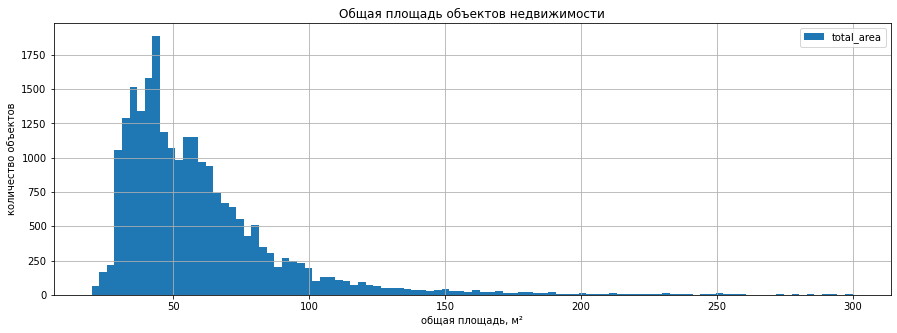

In [54]:
data['total_area'].hist(bins=100, range=(20, 300), figsize=(15, 5), legend=True, grid=True)
plt.title('Общая площадь объектов недвижимости')
plt.xlabel('общая площадь, м²')
plt.ylabel('количество объектов');

In [55]:
# По графику можно сказать, что значения больше 250 явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    data[['total_area']].quantile([0.0012, 0.01, .5, .99, .9950]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
    )

,total_area
0.0012,20.00
0.01,25.20
0.5,52.00
0.99,197.21
0.995,248.85


In [56]:
#Для данного столбца я решила отсечь около 0,5% выбросов
good_data = good_data[(good_data['total_area'] > 20) & (good_data['total_area'] < 250)]

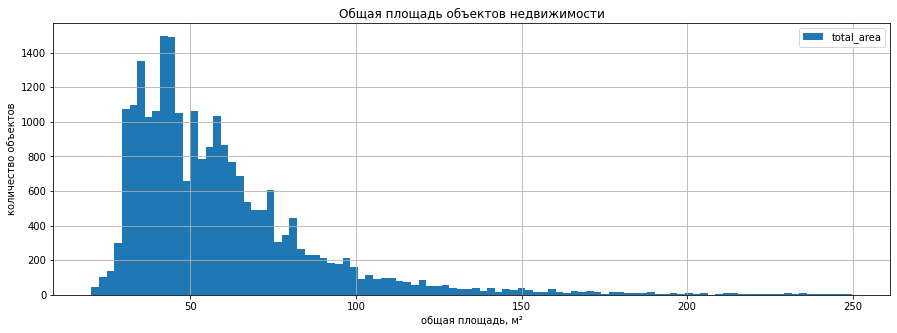

In [57]:
#проверяем график
good_data['total_area'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Общая площадь объектов недвижимости')
plt.xlabel('общая площадь, м²')
plt.ylabel('количество объектов');

In [58]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9936284231402169

Вывод:
<br> В ходе проверки данных общей площади объектов недвижимости найдены выбросы. 99% значений меньше 197 м кв. 
<br> Принято решение ограничить около 0,5% выбросов и выбрать данные в пределах до 250 м. кв.
<br>По полученному графику можно сказать, что чаще всего продаются объекты площадью от 30 до 40м, самыми редкими являются объекты меньше 22м и больше 100м. 

### Изучите параметр жилая площадь.

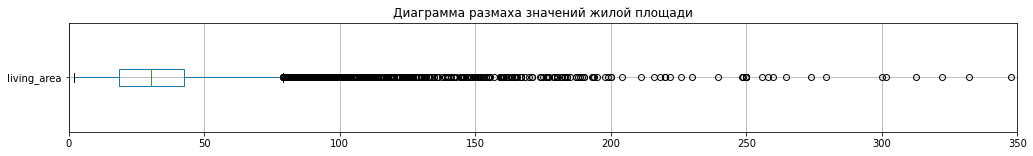

In [59]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0, 350);

In [60]:
good_data['living_area'].describe()#так же посмотрим более точные характеристики

count    23548.000000
mean        33.656761
std         18.680828
min          2.000000
25%         18.400000
50%         30.300000
75%         42.400000
max        220.000000
Name: living_area, dtype: float64

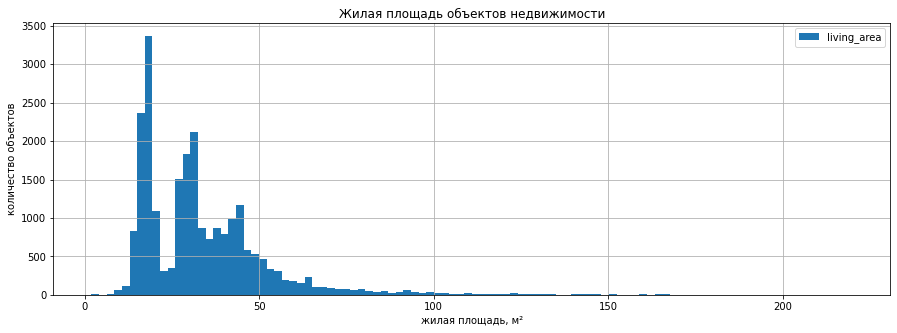

In [63]:
good_data['living_area'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Жилая площадь объектов недвижимости')
plt.xlabel('жилая площадь, м²')
plt.ylabel('количество объектов');

In [64]:
# По графику можно сказать, что значения больше 100 явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    good_data[['living_area']].quantile([0.0012, 0.01, .5, .99, .9950]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
    )

,living_area
0.0012,10.00
0.01,13.10
0.5,30.30
0.99,103.60
0.995,123.93


In [65]:
#Для данного столбца я решила отсечь около 0.5% выбросов
good_data = good_data[(good_data['living_area'] > 10) & (good_data['living_area'] < 120)]

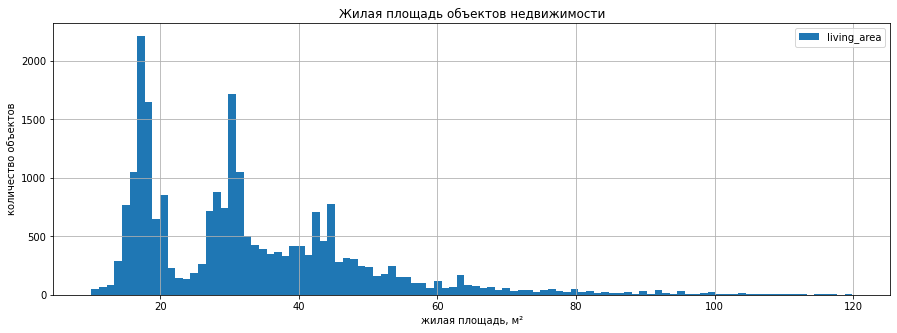

In [66]:
good_data['living_area'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Жилая площадь объектов недвижимости')
plt.xlabel('жилая площадь, м²')
plt.ylabel('количество объектов');

In [67]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9854424237309591

 Вывод:
<br> В ходе проверки данных жилой площади объектов недвижимости найдены выбросы. 99% значений находятся в границах от 10 до 120м, всё, что больше являяется редкостями. В данном случае я убрала из выборки 1% данных.
<br>По полученному графику можно сказать, что чаще всего продаются объекты площадью примерно от 15 до 18м, так же популярны от 30 до 33м, редкими являются объекты меньше 15м и больше 60м. 

### Изучите параметр площадь кухни.

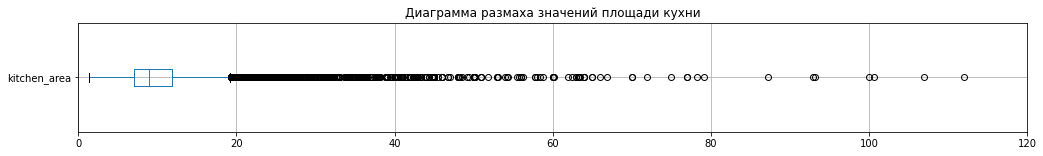

In [68]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади кухни')
ax.set_xlim(0, 120);

In [69]:
good_data['kitchen_area'].describe()#так же посмотрим более точные характеристики

count    23354.000000
mean        10.205092
std          5.378369
min          1.300000
25%          7.000000
50%          9.000000
75%         11.647500
max        107.000000
Name: kitchen_area, dtype: float64

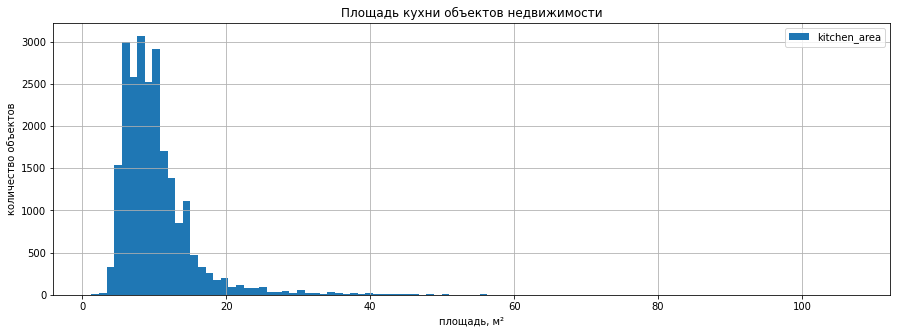

In [72]:
good_data['kitchen_area'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Площадь кухни объектов недвижимости')
plt.xlabel('площадь, м²')
plt.ylabel('количество объектов');

In [73]:
# По графику можно сказать, что значения больше 40 явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    good_data[['kitchen_area']].quantile([0.0012, 0.01, .5, .99, .9939]) 
    .style.format("{:,.2f}")
    )

,kitchen_area
0.0012,3.40
0.01,4.12
0.5,9.00
0.99,32.00
0.9939,37.02


In [74]:
#Для данного столбца я решила отсечь около 0.51% выбросов
good_data = good_data[(good_data['kitchen_area'] > 2.93) & (good_data['kitchen_area'] < 40)]

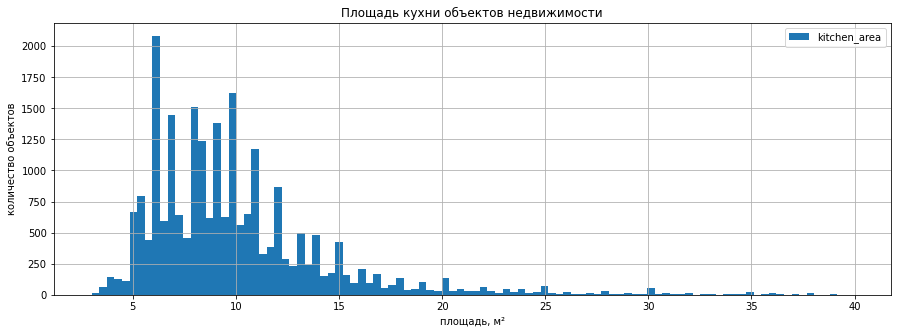

In [75]:
good_data['kitchen_area'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Площадь кухни объектов недвижимости')
plt.xlabel('площадь, м²')
plt.ylabel('количество объектов');

In [76]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9802101354487531

In [77]:
len(good_data)

23230

Вывод:
<br> В ходе проверки данных площади кухни объектов недвижимости найдены аномалии, по графику видно, что это все, что больше 40м. 
<br> В результате было удалено 0,5% аномальных данных.
<br>По полученному графику можно сказать, что чаще всего продаются объекты с площадью кухни примерно 6м и 10м, далее 7 и 9 м, редкими являются объекты меньше 5м и наблюдаются просадки на не целых значениях площади.  

### Изучите параметр цена объекта.

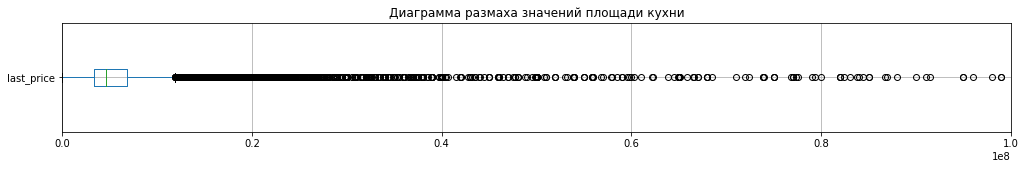

In [78]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади кухни')
ax.set_xlim(0, 100000000);

In [79]:
good_data['last_price'].describe().round()#так же посмотрим более точные характеристики

count        23230.0
mean       5910202.0
std        5548603.0
min         430000.0
25%        3400000.0
50%        4600000.0
75%        6627625.0
max      289238400.0
Name: last_price, dtype: float64

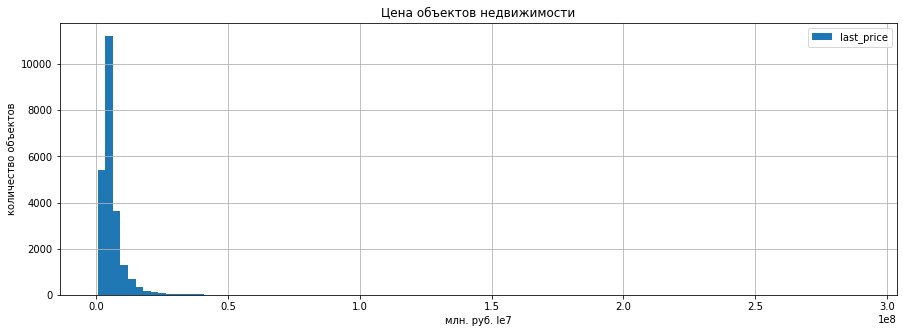

In [82]:
good_data['last_price'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Цена объектов недвижимости')
plt.xlabel('млн. руб. le7')
plt.ylabel('количество объектов');

In [83]:
# По графику можно сказать, что значения больше 10 000 000 явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    good_data[['last_price']].quantile([0.0012, 0.01, .5, .99, .993]) 
    .style.format("{:,.2f}")
    )

,last_price
0.0012,"564,374.00"
0.01,"1,000,000.00"
0.5,"4,600,000.00"
0.99,"26,452,395.52"
0.993,"29,999,000.00"


In [84]:
#Для данного столбца я решила отсечь 1% выбросов
good_data = good_data[good_data['last_price'] < 36000000]

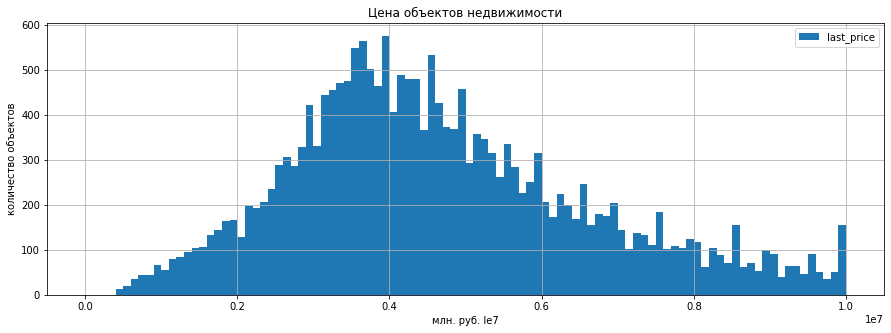

In [85]:
good_data['last_price'].hist(bins=100, figsize=(15, 5),range=(0, 10000000),legend=True, grid=True)
plt.title('Цена объектов недвижимости')
plt.xlabel('млн. руб. le7')
plt.ylabel('количество объектов');

In [86]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9757373728849319

Вывод:
<br> В ходе проверки данных по цене объектов недвижимости найдены выбросы. Нормальные значения находятся в границах до 10 млн. руб., всё, что больше являяется выбросами и такие значения составляют 11,5% от общего количества, это значительная часть данных,поэтому из данных было удалено только 1% выбросов.
<br>По полученному графику можно сказать, что чаще всего продаются объекты цене примерно 4 млн. руб.

### Изучите параметр количество комнат.

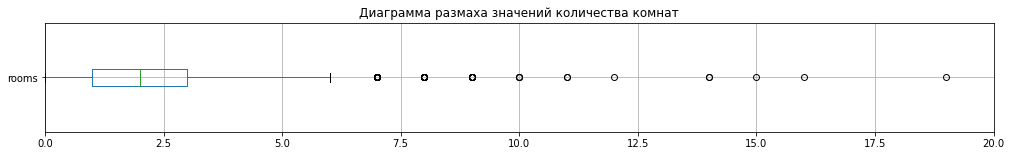

In [87]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['rooms']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений количества комнат')
ax.set_xlim(0, 20);

In [88]:
good_data['rooms'].describe().round()#так же посмотрим более точные характеристики

count    23124.0
mean         2.0
std          1.0
min          0.0
25%          1.0
50%          2.0
75%          3.0
max          8.0
Name: rooms, dtype: float64

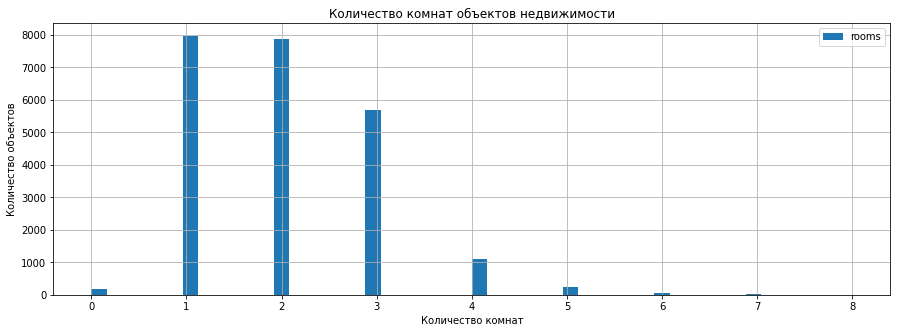

In [92]:
good_data['rooms'].hist(bins=50, figsize=(15, 5), legend=True, grid=True)
plt.title('Количество комнат объектов недвижимости')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов');

In [93]:
# По графику можно сказать, что значения больше 7 явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    good_data[['rooms']].quantile([0.0012, 0.01, .5, .99, .997]) 
    .style.format("{:,.2f}")
    )

,rooms
0.0012,0.00
0.01,1.00
0.5,2.00
0.99,5.00
0.997,5.00


In [94]:
#Для данного столбца я решила отсечь около 0,3% выбросов, уберем все, что больше или равно 7.
good_data = good_data[(good_data['rooms'] > 0) & (good_data['rooms'] < 7)]

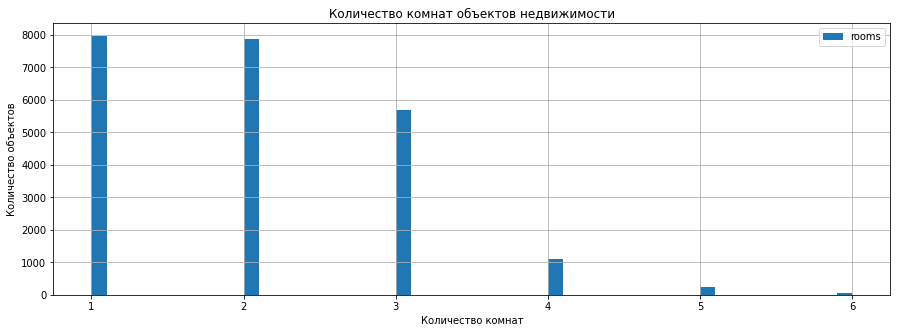

In [95]:
good_data['rooms'].hist(bins=50, figsize=(15, 5), legend=True, grid=True)
plt.title('Количество комнат объектов недвижимости')
plt.xlabel('Количество комнат')
plt.ylabel('Количество объектов');

In [96]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9673825899826997

Вывод:
<br> В ходе проверки данных по количеству комнат недвижимости найдены выбросы. Нормальные значения находятся в границах от 1 до 6 комнат, всё, что больше являяется выбросами и такие значения составляют 0,4% от общего количества, поэтому они не повлияют на данные, просто уберем эти выбросы.
<br>По полученному графику можно сказать, что чаще всего продаются объекты с одной и двумя комнатами.

### Изучите параметр высота потолков.

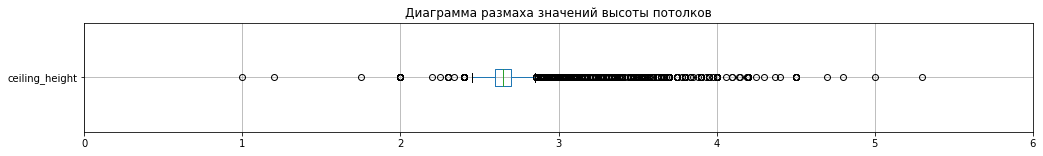

In [97]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = good_data[['ceiling_height']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений высоты потолков')
ax.set_xlim(0, 6);

In [98]:
good_data['ceiling_height'].describe().round(2)#так же посмотрим более точные характеристики

count    22926.00
mean         2.72
std          0.99
min          1.00
25%          2.60
50%          2.65
75%          2.70
max        100.00
Name: ceiling_height, dtype: float64

In [99]:
"""мы видим, что максимальная высота потолков -100м, это явная ошибка, скорее всего это 10м, 
поэтому значения от 20м до 100м разделим на 10"""
good_data.loc[good_data['ceiling_height'] >=20,'ceiling_height'] = good_data['ceiling_height']/10
#good_data['ceiling_height'].sort_values(ascending=False)

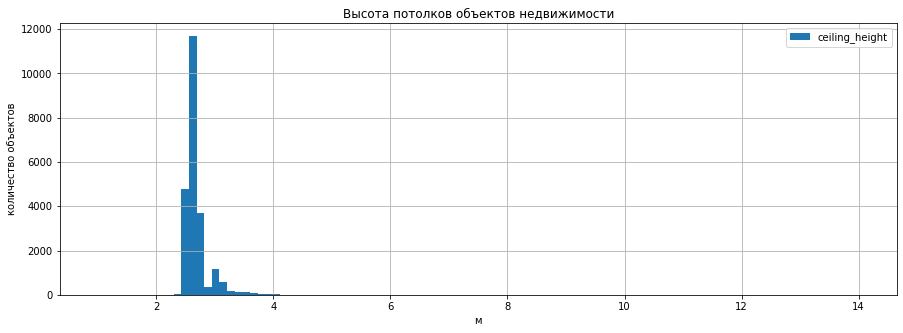

In [102]:
good_data['ceiling_height'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Высота потолков объектов недвижимости')
plt.xlabel('м')
plt.ylabel('количество объектов');

In [103]:
# По графику можно сказать, что значения больше 4 м явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    good_data[['ceiling_height']].quantile([0.001, 0.01, .5, .99, .998]) 
    .style.format("{:,.2f}")
    )

,ceiling_height
0.001,2.40
0.01,2.50
0.5,2.65
0.99,3.50
0.998,4.00


In [104]:
#Для данного столбца я решила отсечь около 0,3% выбросов, уберем все, что меньше 2.4 и больше 3.9
good_data = good_data[(good_data['ceiling_height'] > 2.4) & (good_data['ceiling_height'] < 3.9)]

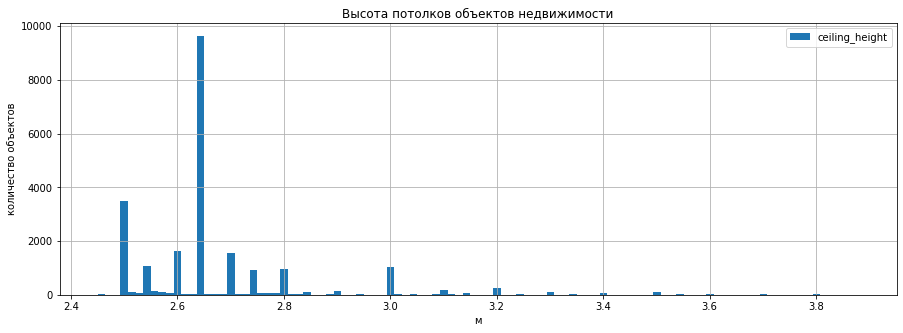

In [105]:
good_data['ceiling_height'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Высота потолков объектов недвижимости')
plt.xlabel('м')
plt.ylabel('количество объектов');

In [106]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9618127347145449

Вывод:
<br> В ходе проверки данных по высоте потолков недвижимости найдены аномальные значения, их удалось исправить, поменяв разрядность числа.
<br> Удалено около 0,3% редких значение: все, что меньше 2.4 и больше 3.9 м.
<br>По полученному графику можно сказать, что чаще всего продаются объекты с высотой потолков 2,65м и 2,5м.
<br>Пропущенные значения заполнены медианным - 2,65м, что и подтверждается данным графиком. Если бы было принято решение не заполнять пропуски медианным значением, то самые продаваемые объекты имели бы высоту 2,5м.

### Изучите параметр тип этажа квартиры («первый», «последний», «другой»).

In [107]:
good_data['type_floor'].value_counts()#посмотрим соотношение данных по их категоризации

средний      16798
последний     3167
первый        2829
Name: type_floor, dtype: int64

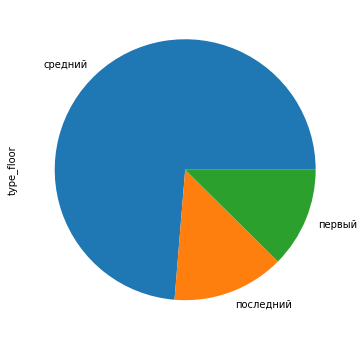

In [108]:
good_data['type_floor'].value_counts().plot(kind='pie', figsize=(10, 6));#распределение объявлений по типу этажа

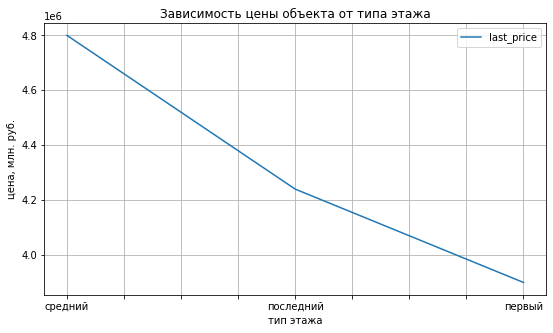

In [109]:
(
    good_data.pivot_table(index='type_floor', values='last_price', aggfunc='median')
    .sort_values(by='last_price', ascending=False)
    .plot(grid=True, figsize=(9, 5), ylabel='цена, млн. руб.', xlabel='тип этажа', title='Зависимость цены объекта от типа этажа')
);

Вывод:
<br> В ходе проверки данных по типу этажа недвижимости выяснено, что наименьшей популярностью пользуется первый этаж. Дешевле всего квартиры на 1-м этаже - около 4 млн. руб, квартиры на последнем этаже дороже - 4.2 млн. руб, но они всё так же дешевле, чем квартиры на других этажах - около 4.8 млн руб.

### Изучите параметр общее количество этажей в доме.

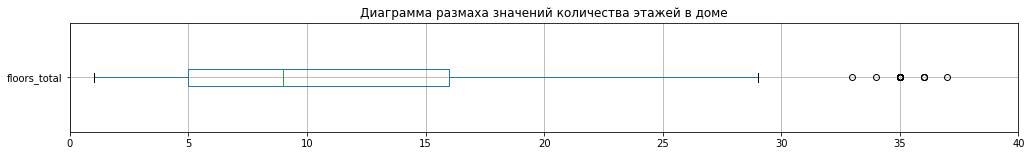

In [110]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['floors_total']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений количества этажей в доме')
ax.set_xlim(0, 40);

In [111]:
data['floors_total'].describe().round(2)#так же посмотрим более точные характеристики

count    23699.00
mean        10.68
std          6.60
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

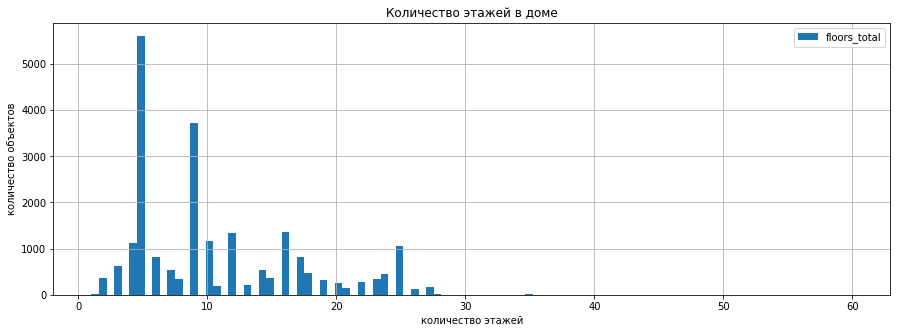

In [115]:
good_data['floors_total'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Количество этажей в доме')
plt.xlabel('количество этажей')
plt.ylabel('количество объектов');

In [116]:
# По графику можно сказать, что значения больше 30  явно редкие.
# Для одного столбца допускаем не больше 1% потерь, проверим это через вычисление процентилей
(
    good_data[['floors_total']].quantile([0.001, 0.01, .5, .99, .998]) 
    .style.format("{:,.2f}")
    )

,floors_total
0.001,1.00
0.01,2.00
0.5,9.00
0.99,26.00
0.998,28.00


In [117]:
#Для данного столбца я решила отсечь около 0,2% выбросов, уберем все, что меньше 2.4 и больше 3.9
good_data = good_data[good_data['floors_total'] < 28]

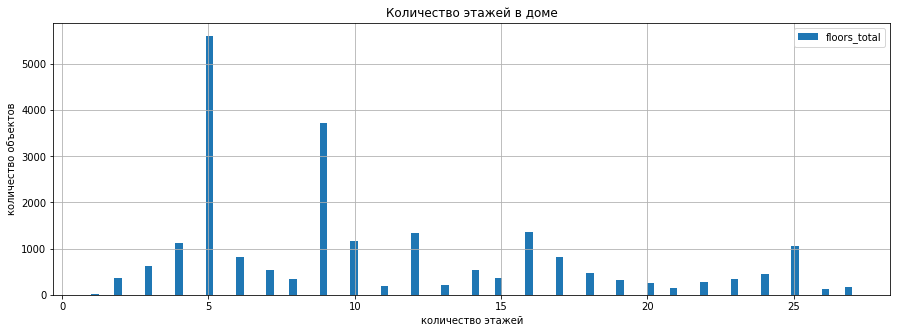

In [118]:
good_data['floors_total'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Количество этажей в доме')
plt.xlabel('количество этажей')
plt.ylabel('количество объектов');

In [119]:
#проверяем процент потерь
good_data.shape[0]/data.shape[0]

0.9596607451791215

Вывод:
<br> В ходе проверки данных по количеству этажей в доме найдены выбросы - все значения больше 28, их процент от общего количества значений составляем - 0,3%, поэтому их из выборки убрала. Выяснено, что чаще всего продаются квартиры в 5-этажных и 9-этажных домах. 

### Изучите параметр расстояние до центра города в метрах.

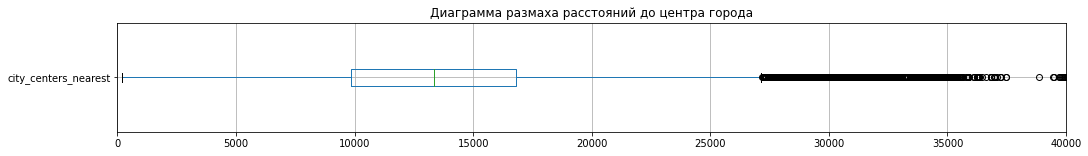

In [120]:
#строим диаграмму размаха, чтобы оценить выбросы
fig, ax = plt.subplots(figsize = (17,2))
ax = good_data[['city_centers_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха расстояний до центра города')
ax.set_xlim(0, 40000);

In [121]:
good_data['city_centers_nearest'].describe().round(2)#так же посмотрим более точные характеристики

count    17979.00
mean     14659.64
std       8577.47
min        181.00
25%       9867.00
50%      13360.00
75%      16788.00
max      65968.00
Name: city_centers_nearest, dtype: float64

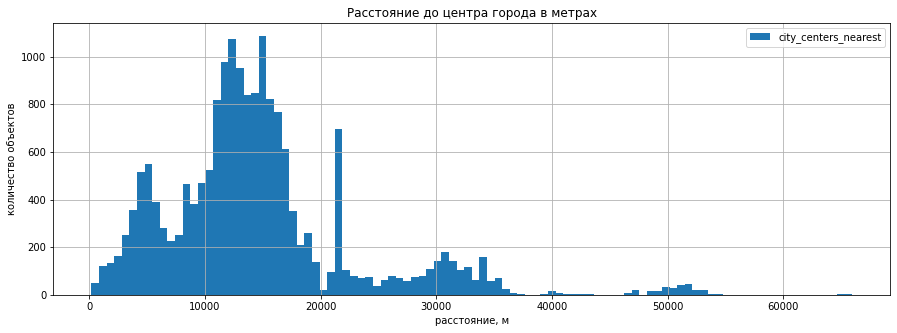

In [124]:
good_data['city_centers_nearest'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Расстояние до центра города в метрах')
plt.xlabel('расстояние, м')
plt.ylabel('количество объектов');


Вывод:
<br> При анализе данных по расстоянию до центра слишком редких значений не наблюдается.
<br> выяснено, что чаще продаются объекты на расстоянии до 22 000 м. А так же пики 15 000 м и 12000 м. 

### Изучите параметр расстояние до ближайшего парка.

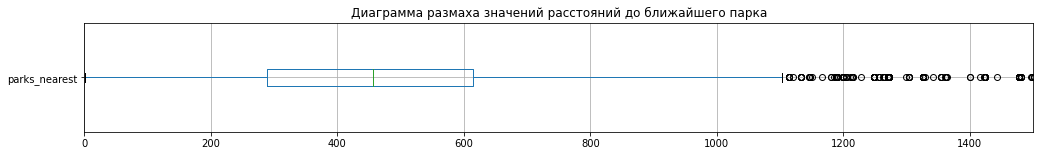

In [125]:
fig, ax = plt.subplots(figsize = (17,2))
ax = good_data[['parks_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений расстояний до ближайшего парка')
ax.set_xlim(0, 1500);

In [126]:
good_data['parks_nearest'].describe().round(2)#так же посмотрим более точные характеристики

count    7616.00
mean      493.91
std       343.90
min         1.00
25%       289.00
50%       456.00
75%       615.00
max      3190.00
Name: parks_nearest, dtype: float64

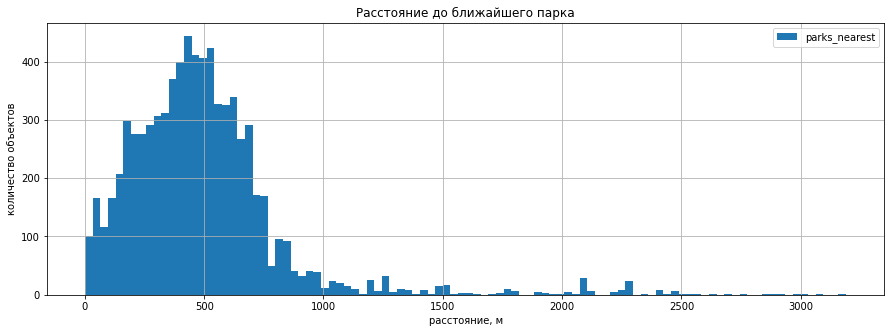

In [130]:
good_data['parks_nearest'].hist(bins=100, figsize=(15, 5), legend=True, grid=True)
plt.title('Расстояние до ближайшего парка')
plt.xlabel('расстояние, м')
plt.ylabel('количество объектов');

Вывод:
<br> При анализе данных по расстоянию до ближайшего парка слишком редких значений не наблюдается.
<br> По полученному графику можно сказать, что количество предложений не зависит от удаленности до ближайшего парка.
<br> Для получения точной картины не хватает данных в столбце расстояние до ближайшего парка, а так же нет возможности заполнить их. 

In [134]:
good_data.shape[0]/data.shape[0] #удалили 4,1% данных

0.9596607451791215

## Изучите, как быстро продавались квартиры (столбец days_exposition).

In [143]:
good_data['days_exposition'].describe()

count    19751.000000
mean       179.371525
std        217.996205
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

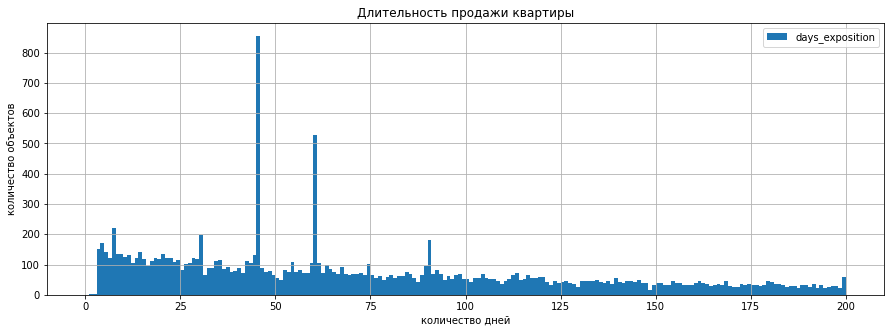

In [144]:
good_data['days_exposition'].hist(bins=200, figsize=(15, 5), range=(0,200), legend=True, grid=True)
plt.title('Длительность продажи квартиры')
plt.xlabel('количество дней')
plt.ylabel('количество объектов');

In [145]:
good_data['days_exposition'].describe().round(0)

count    19751.0
mean       179.0
std        218.0
min          1.0
25%         45.0
50%         95.0
75%        229.0
max       1580.0
Name: days_exposition, dtype: float64

Вывод:
<br> Самые быстрие продажи происходят за 45 дней, а самы долгие более 200.
<br> Среднее время продажи - 180 дней, а вот медианное - 95 дней и оно более точное, так как не учитывает аномалии.

### Средняя скорость продажи объектов по годам

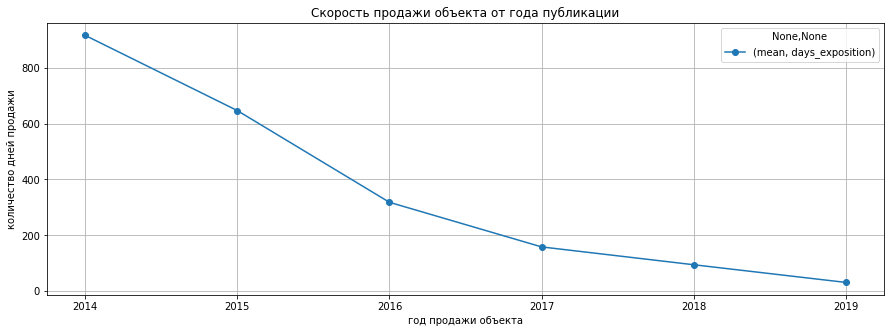

In [146]:
#зависимость от даты публикации
(
good_data.pivot_table(index='day_year_exposition', values='days_exposition', aggfunc=['mean'])
.plot(grid=True, style='o-', figsize=(15, 5))
)
plt.title('Скорость продажи объекта от года публикации')
plt.xlabel('год продажи объекта')
plt.ylabel('количество дней продажи');


Вывод:
<br>Судя по графику, с каждым годом скорость продажи объекта становилась всё меньше. Максимальная в 2014 году - около 900 дней, минимальная в 2019 - 45 дней. 
<br>Предполагаю, что это связано с тем, что со временем вводились различные правила публикации объявлений и дошли до того, что сроки публикации объявления составили от 45 до 90 дней(в зависимости от цены объекта).
<br>По информации из открытого доступа именно так и есть, только к концу 2014 года Яндекс Недвижимость» начал переходить от агрегации к самостоятельному размещению объявлений, соответственно, скорее всего в это время еще не было наработанных правил публикации.   
По графику выше "Длительность продажи квартиры" видим несколько пиков: примерно 45, 60 и 90 дней. Что соответстует сроком актуальности объявления по продаже объекта: до 4,5 млн — 45 дней, от 4,5 до 10 млн — 60 дней, от 10 млн — 90 дней. Если пользователь по истечению указанных сроков не продлил объявление, то оно перестаёт публиковаться. Это значит, что либо эти объекты были проданы в более короткие сроки и пользователь просто не снял объявление, либо пользователь не успел продлить  объявление в указанные сроки. Но тут, конечно, не понятно, может ли пользватель продлить объявление после указанного срока. То есть либо ему нужно будет создавать новое объявление и эта причина отпадает, либо он продлевает объявление позже и оно публикуется снова, то есть уже не попадает в эти пики. 

### Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта.

In [149]:
columns = ['last_price', 'total_area','living_area','kitchen_area','rooms', 'type_floor', 'day_week_exposition',\
'day_month_exposition', 'day_year_exposition' ]
subset = good_data[columns]

In [150]:
subset.corr().round(2)

,last_price,total_area,living_area,kitchen_area,rooms,day_week_exposition,day_month_exposition,day_year_exposition
last_price,1.00,0.77,0.64,0.60,0.48,-0.01,0.01,-0.03
total_area,0.77,1.00,0.91,0.59,0.79,-0.01,0.01,-0.08
living_area,0.64,0.91,1.00,0.35,0.89,-0.01,0.00,-0.07
kitchen_area,0.60,0.59,0.35,1.00,0.23,-0.01,0.02,-0.05
rooms,0.48,0.79,0.89,0.23,1.00,-0.00,0.00,-0.05
day_week_exposition,-0.01,-0.01,-0.01,-0.01,-0.00,1.00,0.01,-0.00
day_month_exposition,0.01,0.01,0.00,0.02,0.00,0.01,1.00,-0.27
day_year_exposition,-0.03,-0.08,-0.07,-0.05,-0.05,-0.00,-0.27,1.00


Вывод:
<br> Стоимость объекта больше всего зависит от общей площади и жилой, так же есть значимая зависимость от количества комнат, дня публикации и площади кухни. Все эти параметры имеют прямую положительную зависимость, то есть, например, чем больше общая площадь, тем больше стоимость объекта.

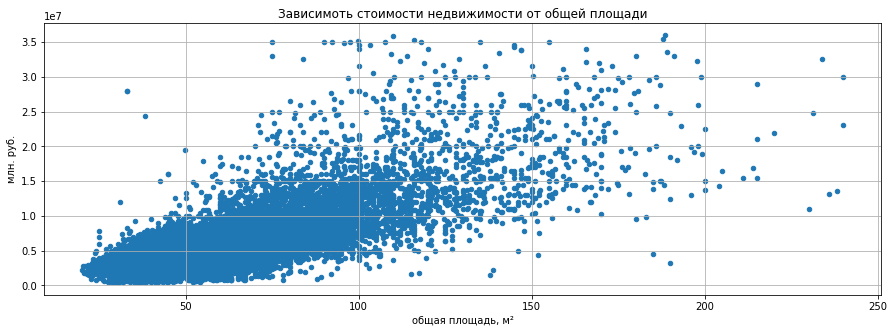

In [151]:
#зависимость от общей площади
good_data.plot(x='total_area', y='last_price', kind='scatter', grid=True, figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от общей площади')
plt.xlabel('общая площадь, м²')
plt.ylabel('млн. руб.');

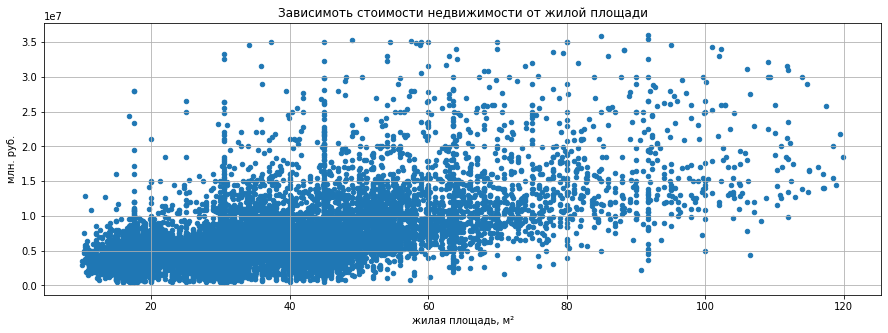

In [152]:
#зависимость от жилой площади
good_data.plot(x='living_area', y='last_price', kind='scatter', grid=True, figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от жилой площади')
plt.xlabel('жилая площадь, м²')
plt.ylabel('млн. руб.');

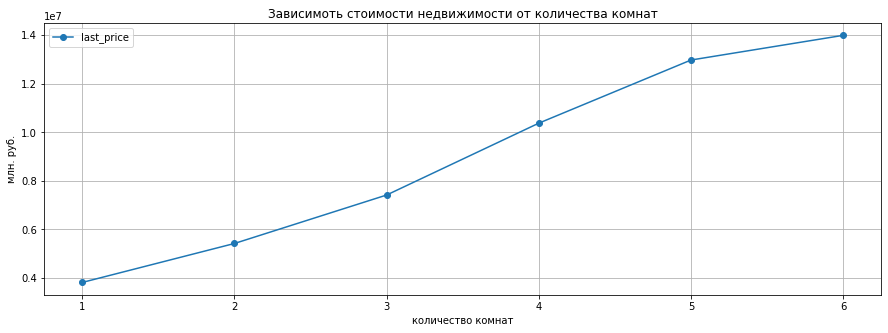

In [153]:
#зависимость от количества комнат
good_data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от количества комнат')
plt.xlabel('количество комнат')
plt.ylabel('млн. руб.');

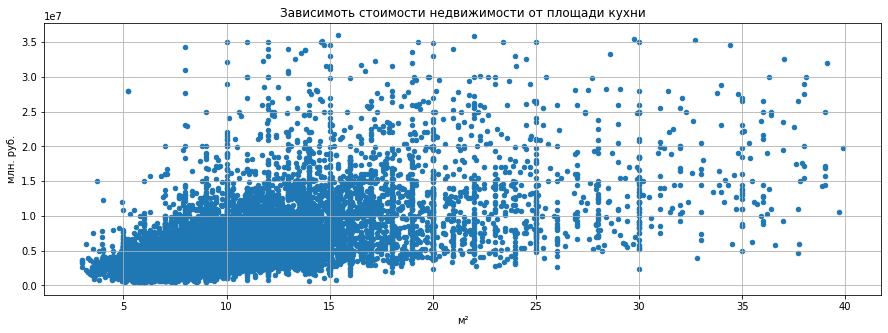

In [154]:
#зависимость от площади кухни
good_data.plot(x='kitchen_area', y='last_price', kind='scatter', grid=True, figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от площади кухни')
plt.xlabel('м²')
plt.ylabel('млн. руб.');

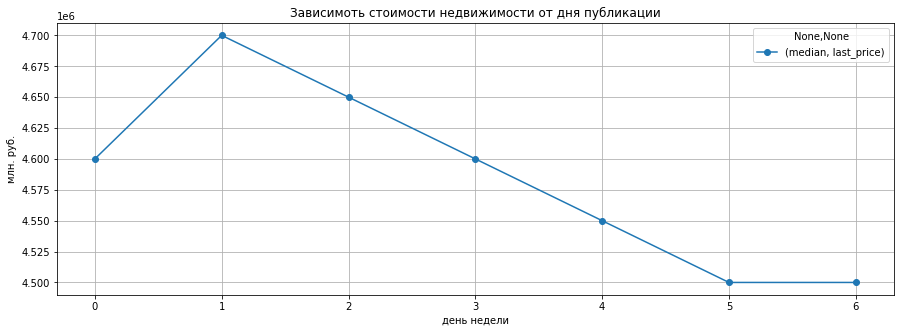

In [155]:
#зависимость от даты публикации
good_data.pivot_table(index='day_week_exposition', values='last_price', aggfunc=['median'])\
.plot(grid=True, style='o-', figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от дня публикации')
plt.xlabel('день недели')
plt.ylabel('млн. руб.');

Вывод:
<br> Стоимость объекта зависит от нескольких параметров: общей, жилой площадей и площади кухни, количества комнат и дня публикации объявления.
<br> Все эти параметры имеют прямую положительную зависимость,то есть чем больше общая площадь объекта или жилая и так далее, тем больше стоимость.Основная масса объектов находится в диапазоне стоимости до 10 млн руб и общей площади 200 м квадратных, жилой до 100 квадратных метров, кухни до 40 квадратных метров. Больше всего публикаций догогих объектов происходит во вторник, далее идет спад. Пики дорогих объектов так же замечены в 4, 9, 10 и 11 месяце.
<br> Самые дорогие объекты находятся на средних этажах, то есть не на первом и не на последнем, средняя стоимость 5 000 000. Самыми дешевыми являются объекты на первом этаже, около 3 800 000, а вот объекты на последнем этаже чуть дороже, около 4 200 000. 
<br>Параметры цены и площади объекта имеют наибольшие пики в 2014 и 2019 годам, в остальные годы наблюдается снижение.
<br>Можно сказать, что цена по годам публикации с 2014 по 2018 год линейно уменьшается, так же и площадь объектов, а в 2019 году наблюдается рост цены и площади объекта. Но вот количество публикаций в 2014 году слишком мало - 136, в 2015 и 2016 есть рост, но он небольшой. Объяснить это можно тем, что только в конце 2014 года Яндекс недвижимость стала переходить к самостоятельной публикации объявлений, из-за чего в 2014 году такое малое количество объявлений, а далее небольшой рост, либо тем, что в исходных данных есть не все записи за указанные годы - технический фактор.
<br> В 2019 году снова наблюдается рост цены и площади объекта, а вот количество объявлений резко падает. Это можно объяснить пандемией, для поддержания рынка недвижимости вводилась льготная ипотека и перевод продаж в электронный формат. 

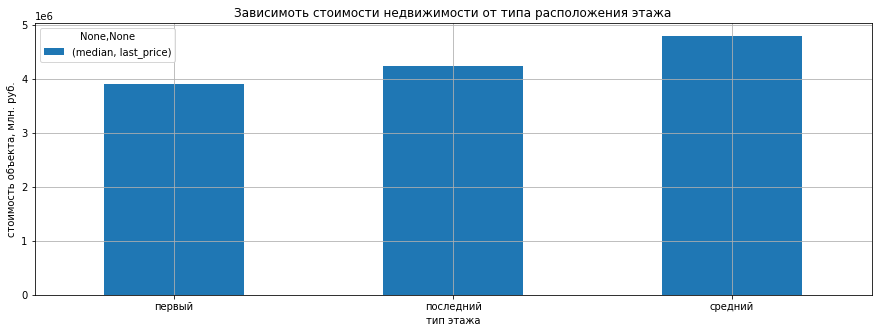

In [156]:
#этаж, на котором расположена квартира
good_data.pivot_table(index='type_floor', values='last_price', aggfunc=['median']).plot(grid=True, kind='bar', rot=0, figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от типа расположения этажа')
plt.xlabel('тип этажа')
plt.ylabel('стоимость объекта, млн. руб.');


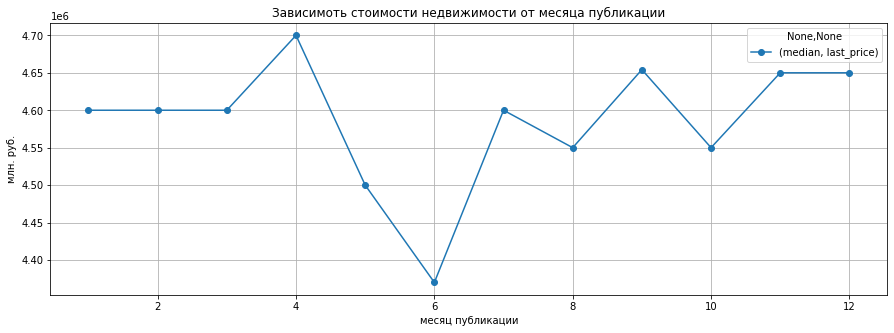

In [157]:
#зависимость от месяца публикации
good_data.pivot_table(index='day_month_exposition', values='last_price', aggfunc=['median'])\
.plot(grid=True, style='o-', figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от месяца публикации')
plt.xlabel('месяц публикации')
plt.ylabel('млн. руб.');

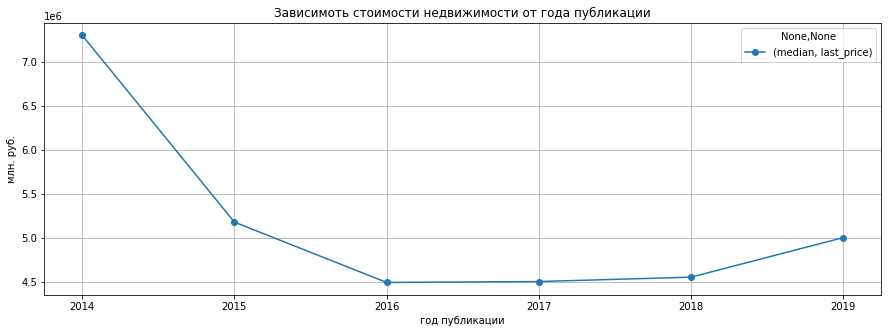

In [158]:
#зависимость от года публикации
good_data.pivot_table(index='day_year_exposition', values='last_price', aggfunc=['median'])\
.plot(grid=True, style='o-', figsize=(15, 5))
plt.title('Зависимоть стоимости недвижимости от года публикации')
plt.xlabel('год публикации')
plt.ylabel('млн. руб.');

In [159]:
#сводная таблица изменения средней цены и площади по годам 
data_pivot = data.pivot_table(index='day_year_exposition', values=['total_area', 'last_price', 'total_images'],\
                 aggfunc={"total_area": 'mean', "last_price": 'mean', 'total_images':len})
data_pivot.columns=['mean_last_price', 'mean_total_area','count']
data_pivot 

,mean_last_price,mean_total_area,count
day_year_exposition,,,
2014,1.208714e+07,86.249854,137
2015,8.572833e+06,71.558371,1191
2016,6.827912e+06,62.156144,2783
2017,6.585729e+06,60.759249,8190
2018,5.950966e+06,57.677386,8519
2019,6.782388e+06,59.467864,2879


### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — постройте сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.

In [160]:
#10 населенных пунктов с наибольшим числом публикаций
price_locality_name = good_data.pivot_table(index='locality_name', values='last_price', aggfunc=['count'])
price_locality_name.columns=['count']
price_locality_name=price_locality_name.sort_values(by='count', ascending=False).head(10)
#выводим цену квадратного метра этих населенных пунктов
price_locality_name['price_meter']=good_data.pivot_table(index='locality_name', values='price_meter').round()
price_locality_name=price_locality_name.sort_values(by='price_meter', ascending=False)
price_locality_name

,count,price_meter
locality_name,,
Санкт-Петербург,14951,110697.0
Пушкин,353,102354.0
Кудрово,282,92286.0
Парголово,316,90402.0
Мурино,519,84903.0
Шушары,434,78408.0
Колпино,336,75352.0
Гатчина,306,68800.0
Всеволожск,388,68608.0


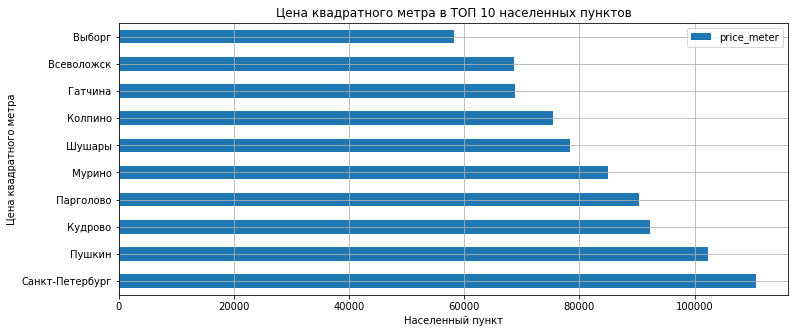

In [161]:
#строим график
price_locality_name['price_meter'].plot(kind='barh', grid=True, figsize=(12,5), legend=True)
plt.title('Цена квадратного метра в ТОП 10 населенных пунктов')
plt.xlabel('Населенный пункт')
plt.ylabel('Цена квадратного метра');

Вывод:
<br> Самая высокая цена заквадратный метр в Санкт-Петербурге, самая низкая в Выборге. 
<br>Из графика следует, что наибольшая средняя цена за 1 кв.м. в Санкт-Петербурге(около 118000 руб.), что логично. Наименьшая цена за квадратный метр в Выборге(около 59000 руб.).

### Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите их среднюю стоимость на разном удалении от центра.

In [162]:
#выделяем квартиры в Санкт-Петербурге
locality_spb = good_data.query('locality_name=="Санкт-Петербург"')
#len(locality_spb)

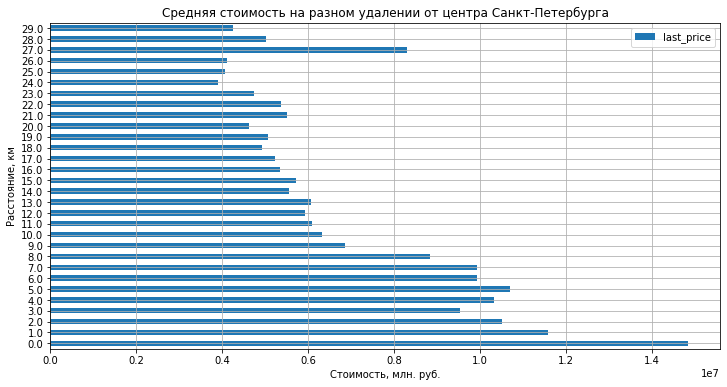

In [163]:
#
locality_spb.pivot_table(index='city_centers_distance', values='last_price')\
.plot(kind='barh', grid=True, figsize=(12, 6),legend=True)
plt.title('Средняя стоимость на разном удалении от центра Санкт-Петербурга')
plt.xlabel('Стоимость, млн. руб.')
plt.ylabel('Расстояние, км');

Вывод:
<br> По полученному графику можно сказать, что существует линейная зависимость - чем дальше от центра города, тем меньше цена, уменьшение начинается с 8 км. На 27 км наблюдается рост цены, это может зависеть от класса жилья - элитные жк, напрмер.
<br>Самое дорогое жилье - около 32 000 000, самое дешевое - меньше 5 000 000.

In [164]:
#посмотрим,что продают на 27 км
#наблюдается малое количество объекстов на 27 км
locality_spb_distance_27=locality_spb[locality_spb['city_centers_distance'] ==27].pivot_table(index='type_floor', \
  values=['living_area', 'last_price', 'total_area', 'rooms'], aggfunc={'living_area':'count', 'last_price':'mean', \
  'total_area':'mean', 'rooms':'mean'})
locality_spb_distance_27.columns = ['price', 'count', 'rooms', 'total_area']
locality_spb_distance_27

,price,count,rooms,total_area
type_floor,,,,
последний,2250000.0,1,1,32.0
средний,14350000.0,1,2,74.0


In [165]:
#посмотрим,сколько объектов с 27 км
locality_spb[locality_spb['city_centers_distance'] > 26].pivot_table(index='city_centers_distance', \
columns=['type_floor'], values=['living_area'], aggfunc='count')

living_area                  
type_floor                 первый последний средний
city_centers_distance                              
27.0                          NaN       1.0     1.0
28.0                          2.0       1.0     4.0
29.0                          4.0       1.0     1.0

С 27 км наблюдается меньшее количество количество объектов, так же на 27 км имеем пропущенное значение, что дает более высокую среднюю стоимость. Поэтому отбросим данные более 27 км как редкие.

In [166]:
#критических потерь нет
(
    locality_spb[['city_centers_distance']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,city_centers_distance
0.0012,1.00
0.01,1.00
0.5,12.00
0.99,23.00
0.9988,26.00


In [167]:
locality_spb = locality_spb[locality_spb['city_centers_distance'] < 27]

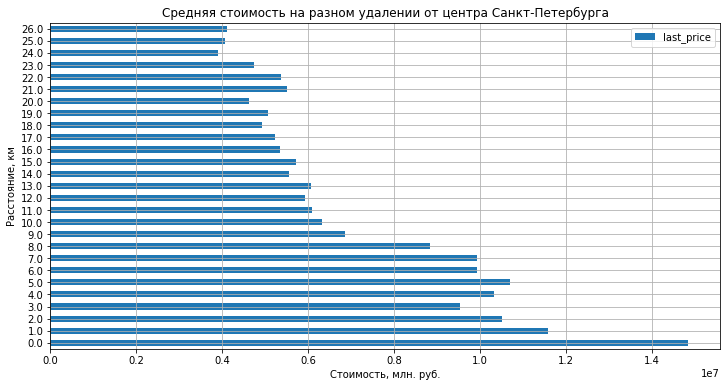

In [168]:
locality_spb.pivot_table(index='city_centers_distance', values='last_price')\
.plot(kind='barh', grid=True, figsize=(12, 6),legend=True)
plt.title('Средняя стоимость на разном удалении от центра Санкт-Петербурга')
plt.xlabel('Стоимость, млн. руб.')
plt.ylabel('Расстояние, км');

 Вывод:
<br /> С 27 км наблюдается меньшее количество количество объектов, так же на 27 км имеем пропущенное значение, что дает более высокую среднюю стоимость. Поэтому ограничили центр до 26 км, на данные не влияет

In [171]:
#ограничим исходные данные по расстоянию от центра 3 и 5 км
locality_spb_km = locality_spb[(locality_spb['city_centers_distance']==3) | (locality_spb['city_centers_distance']==5)]
locality_spb_km

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,price_meter,day_week_exposition,day_month_exposition,day_year_exposition,type_floor,city_centers_distance
63,2,20000000.0,118.0,2018-09-11,3,3.00,9,68.0,7,False,...,648.0,1.0,779.0,37.0,169491.53,1,9,2018,средний,5.0
99,32,9600000.0,90.0,2017-09-26,4,2.65,5,67.0,2,False,...,NaN,0.0,NaN,104.0,106666.67,1,9,2017,средний,3.0
138,8,4800000.0,40.0,2017-11-18,2,2.65,3,29.0,2,False,...,NaN,2.0,729.0,80.0,120000.00,5,11,2017,средний,3.0
141,8,6500000.0,32.6,2019-02-27,1,2.65,5,18.5,5,False,...,NaN,0.0,NaN,NaN,199386.50,2,2,2019,последний,5.0
159,14,7050000.0,66.0,2017-09-04,3,3.00,4,37.8,4,False,...,NaN,1.0,1013.0,98.0,106818.18,0,9,2017,последний,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23559,20,13800000.0,108.6,2016-09-12,3,2.65,19,70.6,7,False,...,NaN,1.0,503.0,354.0,127071.82,0,9,2016,средний,5.0
23588,7,8100000.0,69.0,2015-10-14,2,2.65,10,30.5,8,False,...,NaN,1.0,874.0,823.0,117391.30,2,10,2015,средний,5.0
23590,0,21187872.0,123.3,2017-04-25,3,2.65,22,50.4,18,False,...,NaN,0.0,NaN,104.0,171840.00,1,4,2017,средний,5.0
23664,5,9000000.0,110.0,2015-12-10,4,3.36,7,64.6,5,False,...,417.0,1.0,118.0,816.0,81818.18,3,12,2015,средний,5.0


In [172]:
#создаем сводную таблицу, чтобы посмотреть значения на различном расстоянии
pivot_locality_spb_km = locality_spb_km.pivot_table(index='city_centers_distance', columns = ['type_floor'], \
values='rooms',aggfunc='count', margins=True)
pivot_locality_spb_km 

type_floor,первый,последний,средний,All
city_centers_distance,,,,
3.0,53,72,188,313
5.0,73,122,615,810
All,126,194,803,1123


In [173]:
# чтобы вычислить соотношение нужно каждый элемент строки разделить на сумму в строке
#выбираем 
rows_percent = pivot_locality_spb_km.index
cols_percent = pivot_locality_spb_km.columns[:-1]

# вычисляем сумму каждой строки
row_sums = pivot_locality_spb_km.loc[rows_percent, cols_percent].sum(axis=1)

# # делим каждое значение в выбранных строках и столбцах на сумму соответствующей строки
pivot_locality_spb_km.loc[rows_percent, cols_percent] = pivot_locality_spb_km.loc[rows_percent, cols_percent].divide(row_sums, axis=0)
pivot_locality_spb_km.astype(str).apply(lambda x:x + '%')# перевод в %
pivot_locality_spb_km.round(2)# округление до 2х знаков

type_floor,первый,последний,средний,All
city_centers_distance,,,,
3.0,0.17,0.23,0.60,313
5.0,0.09,0.15,0.76,810
All,0.11,0.17,0.72,1123


Вывод:
<br /> На 3-м километре наблюдается просадка в цене, при анализе объектов на этом расстоянии по отношению к объектам на 5-м км, можно сделать вывод, что просадка в цене появилась из-за того, что на 3-м км больше дешевых объектов на 1 этаже, около 16%, что почти в 2 раза больше, чем на 5-км и больше объектов на последнем этаже, около 23%, а они так же являются менее дорогими. 

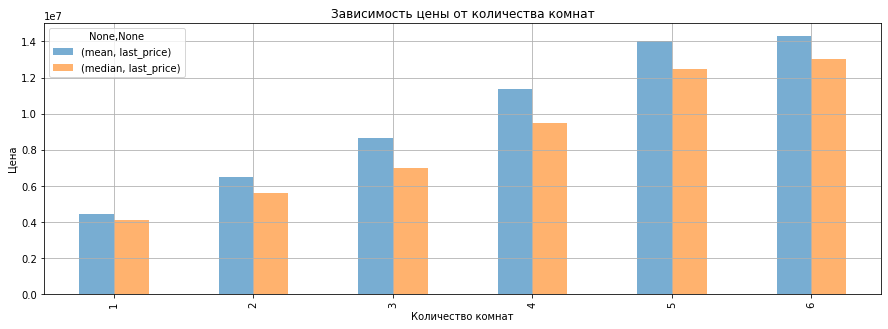

In [174]:
locality_spb.pivot_table(index=['rooms'], values='last_price', aggfunc=['mean', 'median']) \
          .plot(kind='bar', grid=True, linewidth=3, alpha=0.6,figsize=(15,5), title='Зависимость цены от количества комнат')

plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()


In [175]:
data['city_centers_distance'].sort_values(ascending=False)

577      66.0
9640     66.0
5340     66.0
5218     65.0
20746    65.0
         ... 
23683     NaN
23692     NaN
23695     NaN
23696     NaN
23698     NaN
Name: city_centers_distance, Length: 23699, dtype: float64

## Общий вывод

Общий вывод
<br>Наибольшее влияние на стоимость квартиры оказывает её общая и жилая площади, площадь кухни, а так же количество комнат. Чем больше общая и жилая площадь квартиры, а так же кухни, тем выше её стоимость. Чем больше комнат(но чаще до 3-х комнат), тем выше стоимость. На стоимость квартиры также влияет расстояние до центра города (в частности Санкт-Петербурга). Чем ближе квартира располагается к центру, тем выше ее стоимость. Так же дастаточно высокой стоимостью обладают объекты в городе Пушкин, даже квартиры на 1-м этаже, но таких объектов не так много, чем в общем в самом Санкт-Петербурге. 
<br>По итогам исследования можно составить портрет типичного объекта недвижимости: квартира с 1 или 2 комнатами, на 5-ом или 9-ом этаже, общей площадью 30-40 м квадратных, площадью кухни около 10 метров квадратных, с высотой потолков 2,65 м, стоимостью около 4 млн.руб, расположенной на удалении от центра на расстоянии 22 км, до ближайшего парка около 500 метров.
<br>Самые быстрие продажи происходят за 45 дней, а самы долгие более 200. Среднее время продажи - 180 дней, а вот медианное - 95 дней и оно более точное, так как не учитывает аномалии.
<br>Хуже всего продаются квартиры на первом и последнем этаже. 
<br>Самая высокая средняя стоимость квадратного метра в Санкт-Петербурге - 115000 руб./м² (топ-10 населенных пунктов по количеству объявлений).
<br>Самая высокая средняя стоимость объекта в Санкт-Петербурге на расстоянии до 8 км от центра города, далее стоимость начинает уменьшаться. Замечен рост цены в городе Пушкин. 
